In [1]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

from utils.data_augumentation import (Compose, ConvertFromInts, Expand,
                                      PhotometricDistort, RandomMirror,
                                      RandomSampleCrop, Resize, SubtractMeans,
                                      ToAbsoluteCoords, ToPercentCoords)

%matplotlib inline

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
def make_datapath_list(rootpath):
    
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
    
    train_id_names = osp.join(rootpath, 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath, 'ImageSets/Main/val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path =  (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
    
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)  # リストに追加
        val_anno_list.append(anno_path)  # リストに追加

    return train_img_list, train_anno_list, val_img_list, val_anno_list
    

In [4]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 動作確認
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [5]:
class Anno_xml2list():
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, xml_path, width, height):
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
                
            bndbox = []
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in pts:
                cur_pixel = int(bbox.find(pt).text) - 1
                
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                    
                bndbox.append(cur_pixel)
            
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
            
        return np.array(ret)
        

In [6]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

In [7]:
# 画像の読み込み OpenCVを使用
idx = 1
image_file_path = val_img_list[idx]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[idx], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [8]:
class DataTransform():
    def __init__(self, input_size, color_mean):
         self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }
    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)

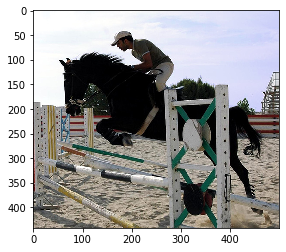

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


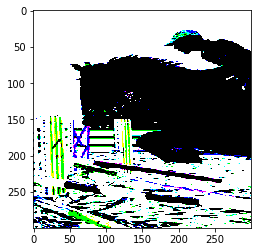

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


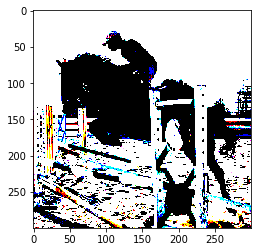

In [9]:
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = "train"
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4])

plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
class VOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape
        
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        img, boxes, labels = self.transform(img, self.phase, anno_list[:,:4], anno_list[:,4])
        
        img = torch.from_numpy(img[:,:,(2,1,0)]).permute(2,0,1)
    
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
#         print(gt.shape)
        
        return img, gt, height, width

In [65]:
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
# val_dataset.__getitem__(1)
val_dataset.pull_item(30)[1]

array([[0.216 , 0.325 , 0.92  , 0.735 , 7.    ],
       [0.    , 0.    , 0.992 , 0.9975, 8.    ]])

In [68]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです
    
#     print(imgs)
    imgs = torch.stack(imgs, dim=0)
#     print(targets.size)
    
    return imgs, targets

In [70]:
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(targets)
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数

torch.Size([4, 3, 300, 300])
[tensor([[ 0.0660,  0.0267,  0.8940,  0.7787, 19.0000]]), tensor([[ 0.0900,  0.0300,  0.9980,  0.9970, 18.0000],
        [ 0.1220,  0.5676,  0.1640,  0.7267, 14.0000]]), tensor([[0.0000, 0.6107, 0.8540, 0.7787, 3.0000]]), tensor([[0.4320, 0.4267, 0.5860, 0.5867, 9.0000],
        [0.9280, 0.4427, 0.9980, 0.5787, 9.0000]])]
4
torch.Size([2, 5])


In [61]:
tuple(zip(*[[3,2,1],[-1,2,3]]))

((3, -1), (2, 2), (1, 3))